In [1]:
import yfinance as yf
import pandas as pd
import time
from datetime import datetime
import matplotlib.pyplot as plt
import squarify
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
from matplotlib.patheffects import withStroke


In [2]:


# # OMXS30 tickers information
# omxs30_info = [
#     {"SymbolYahoo": "ATCO-A.ST", "BaseSymbol": "ATCO", "Sector": "Industrials"},
#     {"SymbolYahoo": "ATCO-B.ST", "BaseSymbol": "ATCO", "Sector": "Industrials"},
#     {"SymbolYahoo": "ABB.ST",    "BaseSymbol": "ABB",  "Sector": "Industrials"},
#     {"SymbolYahoo": "AZN.ST",    "BaseSymbol": "AZN",  "Sector": "Healthcare"},
#     {"SymbolYahoo": "INVE-B.ST", "BaseSymbol": "INVE", "Sector": "Financials"},
#     {"SymbolYahoo": "VOLV-B.ST", "BaseSymbol": "VOLV", "Sector": "Industrials"},
#     {"SymbolYahoo": "NDA-SE.ST", "BaseSymbol": "NDA",  "Sector": "Financials"},
#     {"SymbolYahoo": "ASSA-B.ST", "BaseSymbol": "ASSA", "Sector": "Industrials"},
#     {"SymbolYahoo": "SEB-A.ST",  "BaseSymbol": "SEB",  "Sector": "Financials"},
#     {"SymbolYahoo": "ERIC-B.ST", "BaseSymbol": "ERIC", "Sector": "Technology"},
#     {"SymbolYahoo": "HEXA-B.ST", "BaseSymbol": "HEXA", "Sector": "Technology"},
#     {"SymbolYahoo": "SWED-A.ST", "BaseSymbol": "SWED", "Sector": "Financials"},
#     {"SymbolYahoo": "SAND.ST",   "BaseSymbol": "SAND", "Sector": "Industrials"},
#     {"SymbolYahoo": "SHB-A.ST",  "BaseSymbol": "SHB",  "Sector": "Financials"},
#     {"SymbolYahoo": "HM-B.ST",   "BaseSymbol": "HM",   "Sector": "Consumer Discretionary"},
#     {"SymbolYahoo": "ESSITY-B.ST","BaseSymbol": "ESSITY","Sector": "Consumer Staples"},
#     {"SymbolYahoo": "ALFA.ST",   "BaseSymbol": "ALFA", "Sector": "Industrials"},
#     {"SymbolYahoo": "EVO.ST",    "BaseSymbol": "EVO",  "Sector": "Technology"},
#     {"SymbolYahoo": "SAAB-B.ST", "BaseSymbol": "SAAB", "Sector": "Industrials"},
#     {"SymbolYahoo": "TELIA.ST",  "BaseSymbol": "TELIA","Sector": "Communication Services"},
#     {"SymbolYahoo": "SKF-B.ST",  "BaseSymbol": "SKF",  "Sector": "Industrials"},
#     {"SymbolYahoo": "SCA-B.ST",  "BaseSymbol": "SCA",  "Sector": "Materials"},
#     {"SymbolYahoo": "BOL.ST",    "BaseSymbol": "BOL",  "Sector": "Materials"},
#     {"SymbolYahoo": "NIBE-B.ST", "BaseSymbol": "NIBE", "Sector": "Industrials"},
#     {"SymbolYahoo": "TEL2-B.ST", "BaseSymbol": "TEL2", "Sector": "Communication Services"},
#     {"SymbolYahoo": "GETI-B.ST", "BaseSymbol": "GETI", "Sector": "Healthcare"},
#     {"SymbolYahoo": "ELUX-B.ST", "BaseSymbol": "ELUX", "Sector": "Consumer Discretionary"},
#     {"SymbolYahoo": "KINV-B.ST", "BaseSymbol": "KINV", "Sector": "Financials"},
#     {"SymbolYahoo": "SINCH.ST",  "BaseSymbol": "SINCH","Sector": "Technology"},
#     {"SymbolYahoo": "SBB-B.ST",  "BaseSymbol": "SBB",  "Sector": "Real Estate"}
# ]



In [3]:
import yfinance as yf
import pandas as pd
import time
from datetime import datetime
import matplotlib.pyplot as plt
import squarify
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.colors as mcolors
from matplotlib.patheffects import withStroke


# OMXS30 tickers information
omxs30_info = [
    {"SymbolYahoo": "ATCO-A.ST", "BaseSymbol": "ATCO", "Sector": "Industrials"},
    {"SymbolYahoo": "ATCO-B.ST", "BaseSymbol": "ATCO", "Sector": "Industrials"},
    {"SymbolYahoo": "ABB.ST",    "BaseSymbol": "ABB",  "Sector": "Industrials"},
    {"SymbolYahoo": "AZN.ST",    "BaseSymbol": "AZN",  "Sector": "Healthcare"},
    {"SymbolYahoo": "INVE-B.ST", "BaseSymbol": "INVE", "Sector": "Financials"},
    {"SymbolYahoo": "VOLV-B.ST", "BaseSymbol": "VOLV", "Sector": "Industrials"},
    {"SymbolYahoo": "NDA-SE.ST", "BaseSymbol": "NDA",  "Sector": "Financials"},
    {"SymbolYahoo": "ASSA-B.ST", "BaseSymbol": "ASSA", "Sector": "Industrials"},
    {"SymbolYahoo": "SEB-A.ST",  "BaseSymbol": "SEB",  "Sector": "Financials"},
    {"SymbolYahoo": "ERIC-B.ST", "BaseSymbol": "ERIC", "Sector": "Technology"},
    {"SymbolYahoo": "HEXA-B.ST", "BaseSymbol": "HEXA", "Sector": "Technology"},
    {"SymbolYahoo": "SWED-A.ST", "BaseSymbol": "SWED", "Sector": "Financials"},
    {"SymbolYahoo": "SAND.ST",   "BaseSymbol": "SAND", "Sector": "Industrials"},
    {"SymbolYahoo": "SHB-A.ST",  "BaseSymbol": "SHB",  "Sector": "Financials"},
    {"SymbolYahoo": "HM-B.ST",   "BaseSymbol": "HM",   "Sector": "Consumer Discretionary"},
    {"SymbolYahoo": "ESSITY-B.ST","BaseSymbol": "ESSITY","Sector": "Consumer Staples"},
    {"SymbolYahoo": "ALFA.ST",   "BaseSymbol": "ALFA", "Sector": "Industrials"},
    {"SymbolYahoo": "EVO.ST",    "BaseSymbol": "EVO",  "Sector": "Technology"},
    {"SymbolYahoo": "SAAB-B.ST", "BaseSymbol": "SAAB", "Sector": "Industrials"},
    {"SymbolYahoo": "TELIA.ST",  "BaseSymbol": "TELIA","Sector": "Communication Services"},
    {"SymbolYahoo": "SKF-B.ST",  "BaseSymbol": "SKF",  "Sector": "Industrials"},
    {"SymbolYahoo": "SCA-B.ST",  "BaseSymbol": "SCA",  "Sector": "Materials"},
    {"SymbolYahoo": "BOL.ST",    "BaseSymbol": "BOL",  "Sector": "Materials"},
    {"SymbolYahoo": "NIBE-B.ST", "BaseSymbol": "NIBE", "Sector": "Industrials"},
    {"SymbolYahoo": "TEL2-B.ST", "BaseSymbol": "TEL2", "Sector": "Communication Services"},
    {"SymbolYahoo": "GETI-B.ST", "BaseSymbol": "GETI", "Sector": "Healthcare"},
    {"SymbolYahoo": "ELUX-B.ST", "BaseSymbol": "ELUX", "Sector": "Consumer Discretionary"},
    {"SymbolYahoo": "KINV-B.ST", "BaseSymbol": "KINV", "Sector": "Financials"},
    {"SymbolYahoo": "SINCH.ST",  "BaseSymbol": "SINCH","Sector": "Technology"},
    {"SymbolYahoo": "SBB-B.ST",  "BaseSymbol": "SBB",  "Sector": "Real Estate"}
]

from datetime import datetime, timedelta
def fetch_data_for_date_range(omxs30_symbols, start_date, end_date):
    """
    Fetch market data between a given date range and calculate percentage changes.
    Raises an error if no valid trading data exists for the specified range.
    """
    data = []

    for symbol in omxs30_symbols:
        try:
            print(f"Fetching data for {symbol}...")

            # Retrieve stock info for market cap
            stock = yf.Ticker(symbol)
            info = stock.info
            market_cap = info.get("marketCap", None)  #Fetch MarketCap

            # Download data for the given date range
            stock_data = yf.download(symbol, start=start_date, end=end_date, interval="1d", progress=False)

            if stock_data.empty:
                raise ValueError(f"No trading data available for {symbol} between {start_date} and {end_date}")

            # Find the first and last valid trading days
            close_start = stock_data["Close"].iloc[0] if not stock_data["Close"].isna().iloc[0] else None
            close_end = stock_data["Close"].iloc[-1] if not stock_data["Close"].isna().iloc[-1] else None

            # Validate data availability within the range
            if close_start is None or close_end is None:
                raise ValueError(f"Invalid trading data for {symbol} in the range {start_date} to {end_date}")

            # Debug: Print close_start and close_end
            print(f"{symbol} - Close Start: {close_start}, Close End: {close_end}")

            # Calculate percentage change
            pct_change = ((close_end - close_start) / close_start) * 100

            # Append to data
            data.append({
                "Symbol": symbol,
                "MarketCap": market_cap,
                "CloseStart": close_start,
                "CloseEnd": close_end,
                "PctChange": pct_change
            })

        except Exception as e:
            print(f"Error fetching data for {symbol}: {e}")
            data.append({
                "Symbol": symbol,
                "MarketCap": None,
                "CloseStart": None,
                "CloseEnd": None,
                "PctChange": None,
                "Error": str(e)
            })

        time.sleep(1)

    return pd.DataFrame(data)

In [16]:
def generate_treemap_for_date_range(omxs30_symbols, omxs30_info, start_date, end_date, custom_title=None):
    """
    Generate a treemap for a given date range.
    Allows an optional custom title for the treemap.
    """
    df_pct_change = fetch_data_for_date_range(omxs30_symbols, start_date, end_date)
    df_info = pd.DataFrame(omxs30_info)
    df_combined = pd.merge(df_info, df_pct_change, left_on="SymbolYahoo", right_on="Symbol", how="left")

    # Combine duplicates
    df_combined["SumMarketCap"] = df_combined["MarketCap"]
    df_combined["WeightedPctChange"] = df_combined["PctChange"]
    df_combined = (
        df_combined
        .groupby(["BaseSymbol", "Sector"], as_index=False)
        .agg({
            "SumMarketCap": "sum",
            "WeightedPctChange": "mean",
        })
    )

    # Generate the treemap
    plot_omxs30_treemap_instagram(df_combined, start_date, end_date, custom_title)

def plot_omxs30_treemap_instagram(df_combined, start_date, end_date, custom_title=None):
    """
    Create a treemap with all numbers displayed under the ticker symbols.
    """
    sector_agg = (
        df_combined
        .groupby("Sector", as_index=False)["SumMarketCap"]
        .sum()
        .rename(columns={"SumMarketCap": "TotalSectorMcap"})
        .sort_values("TotalSectorMcap", ascending=False)
    )

    total_market_cap = sector_agg["TotalSectorMcap"].sum()
    sector_sizes = sector_agg["TotalSectorMcap"].values / total_market_cap * (100 * 100)
    sector_names = sector_agg["Sector"].values
    sector_rects = squarify.squarify(sector_sizes, 0, 0, 100, 100)

    # Use actual data range for normalization
    min_chg = df_combined["WeightedPctChange"].min()
    max_chg = df_combined["WeightedPctChange"].max()

    # Define colormaps
    light_red_to_red = LinearSegmentedColormap.from_list("light_red_to_red", ["#FF0000", "#FFCCCC"])
    light_green_to_strong_green = LinearSegmentedColormap.from_list("light_green_to_strong_green", ["#CCFFCC", "#009900"])

    # Define normalizers based on the data
    norm_neg = mcolors.Normalize(vmin=min_chg, vmax=0)  # For negative values
    norm_pos = mcolors.Normalize(vmin=0, vmax=max_chg)  # For positive values

    fig, ax = plt.subplots(figsize=(10.8, 19.2))
    margin = 1
    ax.set_xlim(-margin, 100 + margin)
    ax.set_ylim(-margin, 103 + margin)
    ax.axis("off")

    for srect, sector_name in zip(sector_rects, sector_names):
        subdf = df_combined[df_combined["Sector"] == sector_name]
        sub_total_market_cap = subdf["SumMarketCap"].sum()
        sub_sizes = subdf["SumMarketCap"].values / sub_total_market_cap * (srect["dx"] * srect["dy"])
        sub_rects = squarify.squarify(sub_sizes, srect["x"], srect["y"], srect["dx"], srect["dy"])

        for sbox, row in zip(sub_rects, subdf.itertuples()):
            chg_val = row.WeightedPctChange
            # Apply normalization based on the change value
            if chg_val >= 0:
                color_rgba = light_green_to_strong_green(norm_pos(chg_val))  # Positive gradient
            else:
                color_rgba = light_red_to_red(norm_neg(chg_val))  # Negative gradient

            ax.add_patch(plt.Rectangle((sbox["x"], sbox["y"]), sbox["dx"], sbox["dy"], facecolor=color_rgba, edgecolor="white"))

            if sbox["dx"] * sbox["dy"] > 2:
                sym = row.BaseSymbol
                label_str = f"{sym}\n{chg_val:.2f}%"
                ax.text(
                    sbox["x"] + sbox["dx"] / 2,
                    sbox["y"] + sbox["dy"] / 2,
                    label_str,
                    ha="center", va="center",
                    fontsize=12, fontweight="bold",
                    color="white",
                    path_effects=[withStroke(linewidth=2, foreground="black")]
                )

        ax.add_patch(
            plt.Rectangle((srect["x"], srect["y"]), srect["dx"], srect["dy"], fill=False, edgecolor="black", linewidth=2)
        )

    # title
    final_title = custom_title if custom_title else f"OMXS30 Treemap ({start_date} to {end_date})"
    fig.suptitle(final_title, fontsize=24, fontweight="bold", y=0.96)

    plt.tight_layout()
    plt.savefig(f'OMXS30_Treemap_{custom_title}.png', dpi=800, bbox_inches="tight")
    plt.show()



#### week 1

Fetching data for ATCO-A.ST...
ATCO-A.ST - Close Start: 171.64999389648438, Close End: 171.64999389648438
Fetching data for ATCO-B.ST...
ATCO-B.ST - Close Start: 152.1999969482422, Close End: 152.85000610351562
Fetching data for ABB.ST...
ABB.ST - Close Start: 593.2000122070312, Close End: 600.4000244140625
Fetching data for AZN.ST...
AZN.ST - Close Start: 1475.5, Close End: 1475.0
Fetching data for INVE-B.ST...
INVE-B.ST - Close Start: 296.0, Close End: 296.70001220703125
Fetching data for VOLV-B.ST...
VOLV-B.ST - Close Start: 269.79998779296875, Close End: 268.70001220703125
Fetching data for NDA-SE.ST...
NDA-SE.ST - Close Start: 122.0999984741211, Close End: 122.4000015258789
Fetching data for ASSA-B.ST...
ASSA-B.ST - Close Start: 327.79998779296875, Close End: 326.8999938964844
Fetching data for SEB-A.ST...
SEB-A.ST - Close Start: 152.75, Close End: 154.3000030517578
Fetching data for ERIC-B.ST...
ERIC-B.ST - Close Start: 90.9000015258789, Close End: 91.0
Fetching data for HEXA-B.S

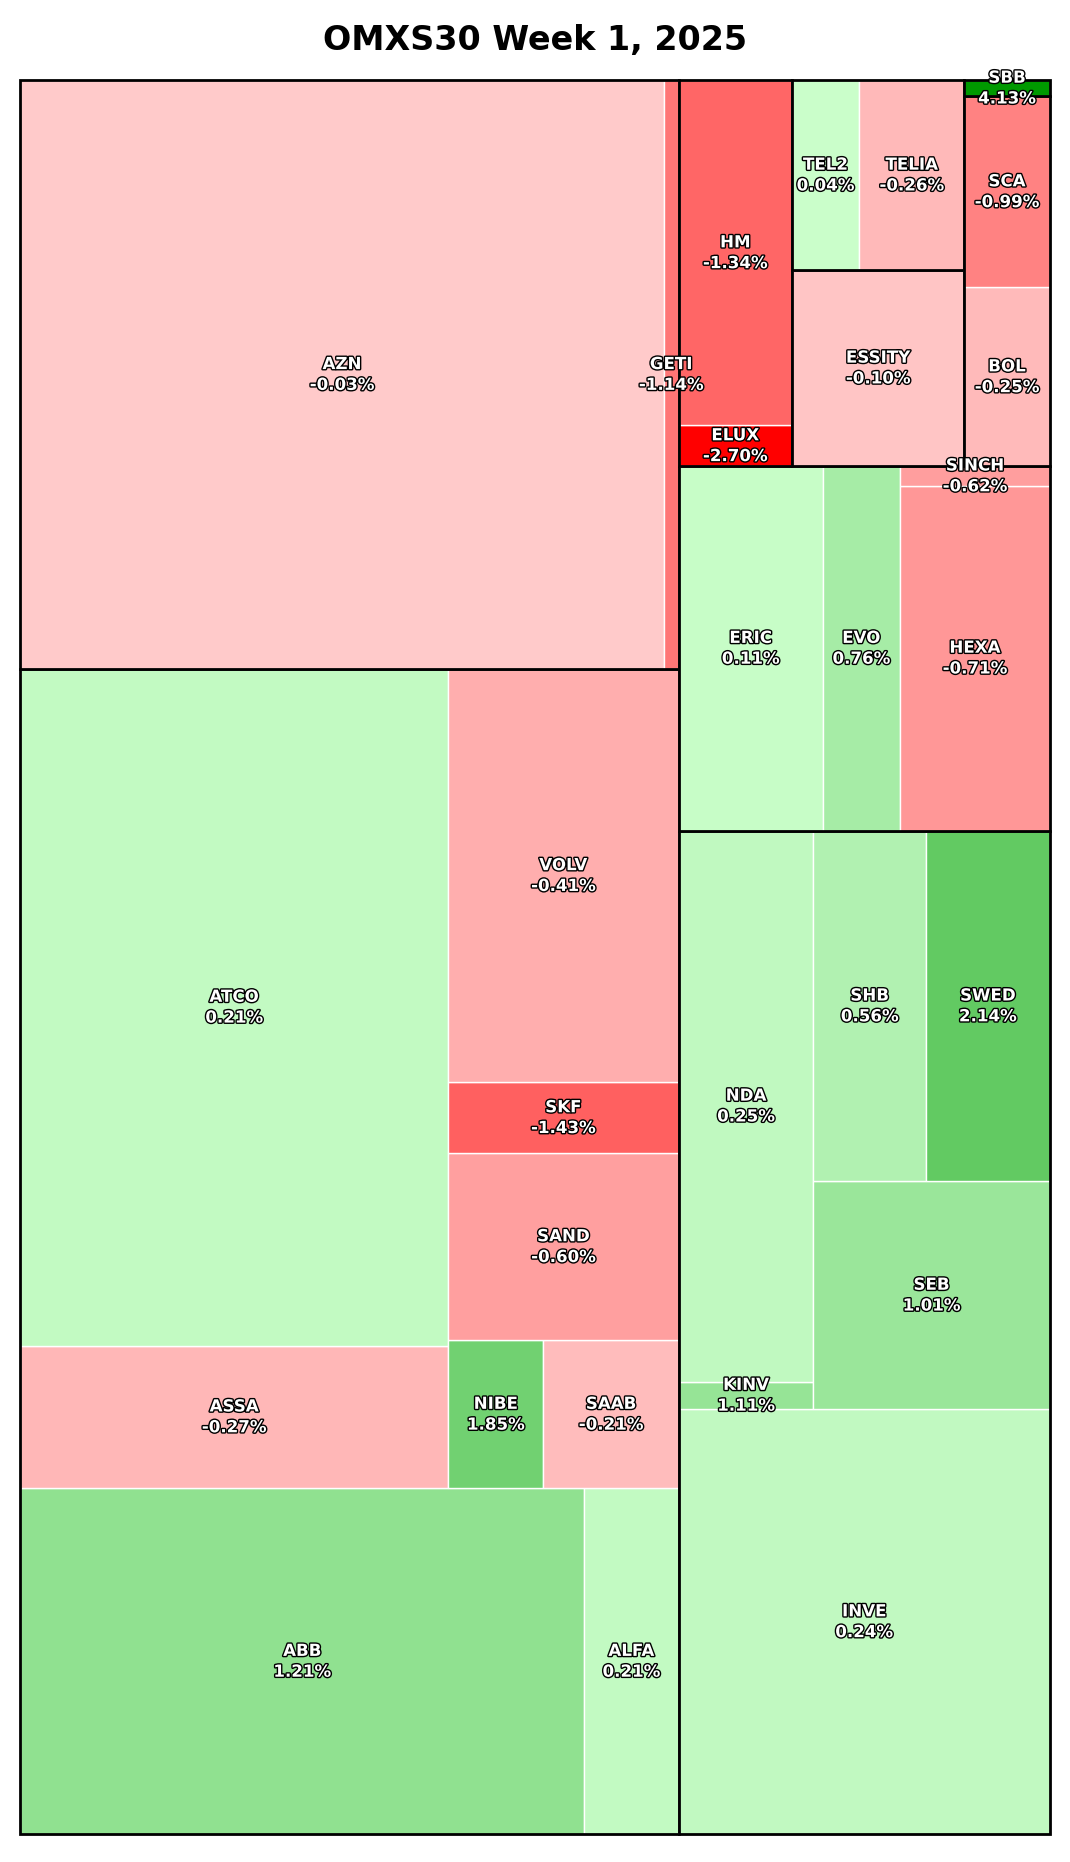

In [17]:

generate_treemap_for_date_range(
    [info["SymbolYahoo"] for info in omxs30_info],
    omxs30_info,
    start_date="2025-01-02",
    end_date="2025-01-04",
    custom_title="OMXS30 Week 1, 2025"
)

#### week 2

Fetching data for ATCO-A.ST...
ATCO-A.ST - Close Start: 175.0500030517578, Close End: 175.64999389648438
Fetching data for ATCO-B.ST...
ATCO-B.ST - Close Start: 154.9499969482422, Close End: 156.9499969482422
Fetching data for ABB.ST...
ABB.ST - Close Start: 603.5999755859375, Close End: 602.5999755859375
Fetching data for AZN.ST...
AZN.ST - Close Start: 1482.0, Close End: 1508.0
Fetching data for INVE-B.ST...
INVE-B.ST - Close Start: 297.70001220703125, Close End: 299.3999938964844
Fetching data for VOLV-B.ST...
VOLV-B.ST - Close Start: 285.1000061035156, Close End: 279.20001220703125
Fetching data for NDA-SE.ST...
NDA-SE.ST - Close Start: 126.8499984741211, Close End: 125.0
Fetching data for ASSA-B.ST...
ASSA-B.ST - Close Start: 324.8999938964844, Close End: 320.0
Fetching data for SEB-A.ST...
SEB-A.ST - Close Start: 155.89999389648438, Close End: 155.14999389648438
Fetching data for ERIC-B.ST...
ERIC-B.ST - Close Start: 91.86000061035156, Close End: 92.58000183105469
Fetching data f

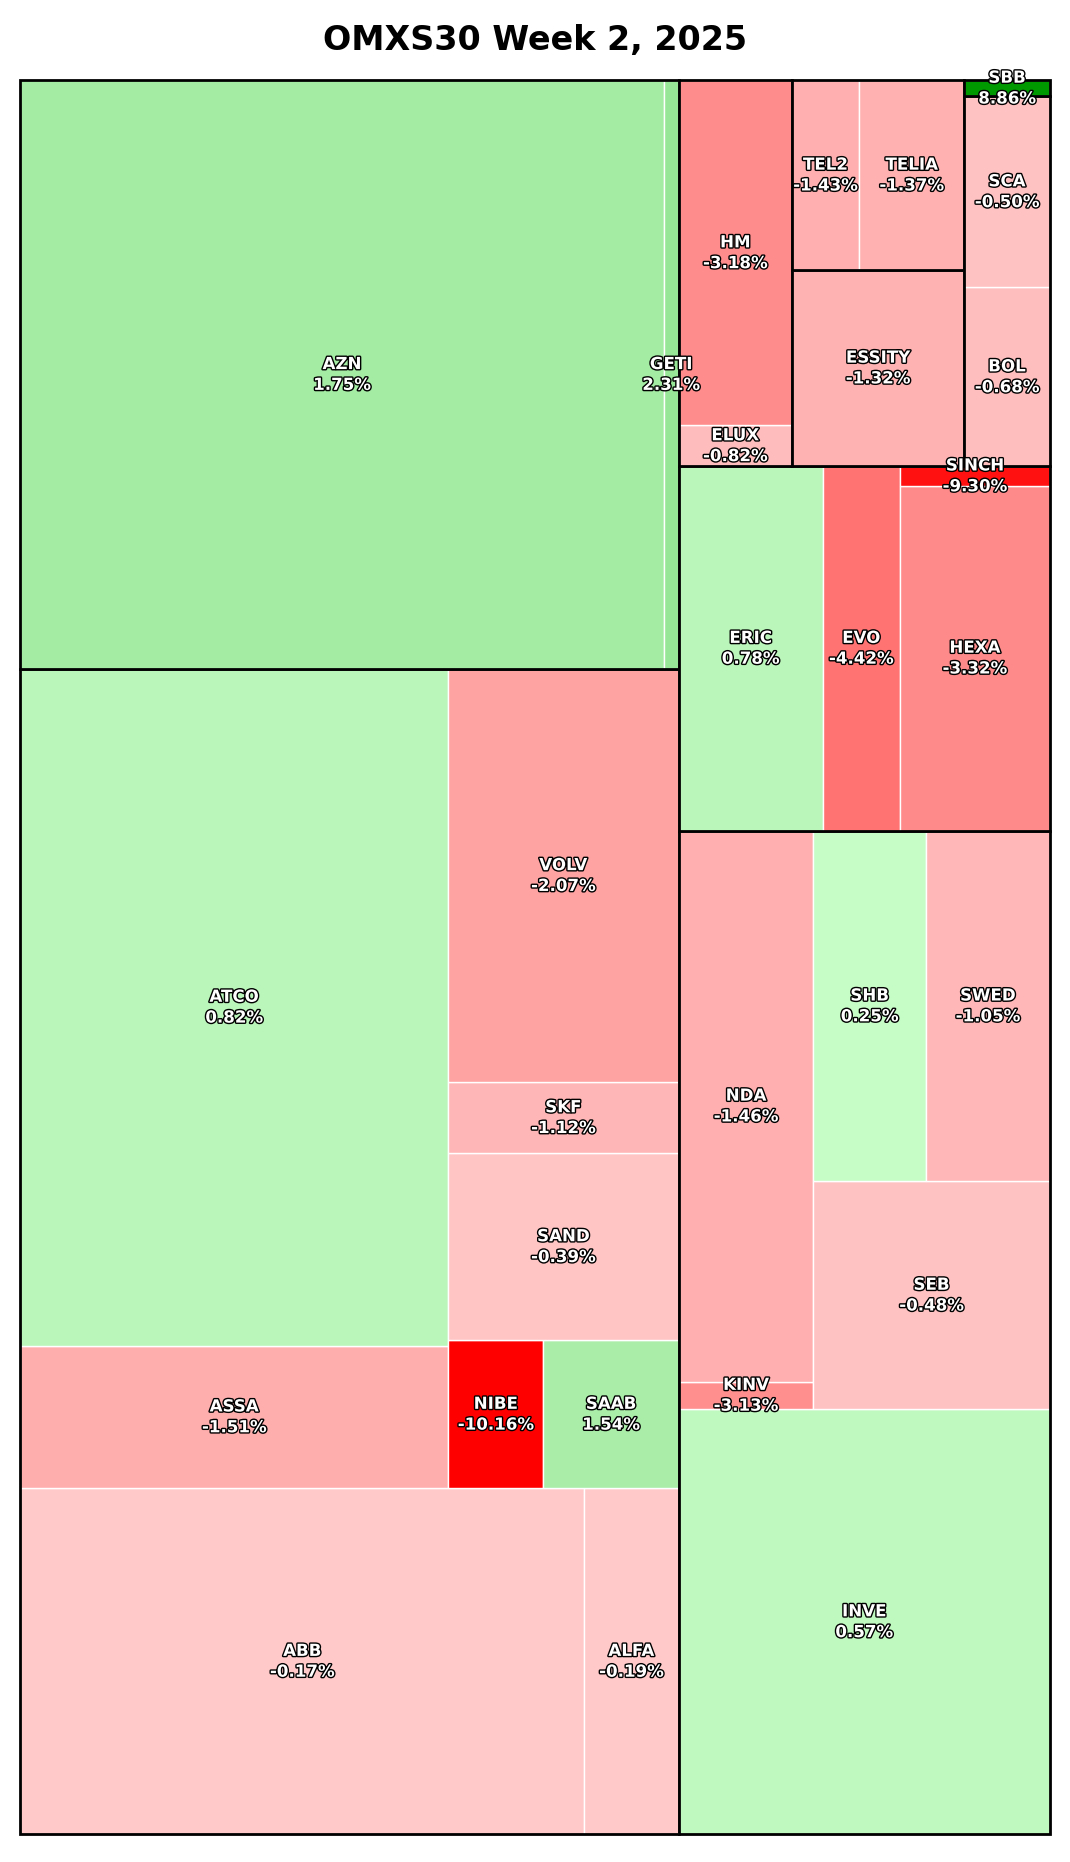

In [18]:
# Example Usage
generate_treemap_for_date_range(
    [info["SymbolYahoo"] for info in omxs30_info],
    omxs30_info,
    start_date="2025-01-07",
    end_date="2025-01-11", 
    custom_title="OMXS30 Week 2, 2025"
)

#### week 3

Fetching data for ATCO-A.ST...
ATCO-A.ST - Close Start: 174.85000610351562, Close End: 186.25
Fetching data for ATCO-B.ST...
ATCO-B.ST - Close Start: 155.9499969482422, Close End: 167.14999389648438
Fetching data for ABB.ST...
ABB.ST - Close Start: 597.0, Close End: 617.7999877929688
Fetching data for AZN.ST...
AZN.ST - Close Start: 1487.0, Close End: 1492.0
Fetching data for INVE-B.ST...
INVE-B.ST - Close Start: 297.5, Close End: 312.8999938964844
Fetching data for VOLV-B.ST...
VOLV-B.ST - Close Start: 276.5, Close End: 288.0
Fetching data for NDA-SE.ST...
NDA-SE.ST - Close Start: 126.4000015258789, Close End: 128.85000610351562
Fetching data for ASSA-B.ST...
ASSA-B.ST - Close Start: 316.8999938964844, Close End: 334.1000061035156
Fetching data for SEB-A.ST...
SEB-A.ST - Close Start: 156.75, Close End: 160.4499969482422
Fetching data for ERIC-B.ST...
ERIC-B.ST - Close Start: 89.66000366210938, Close End: 95.30000305175781
Fetching data for HEXA-B.ST...
HEXA-B.ST - Close Start: 106.400

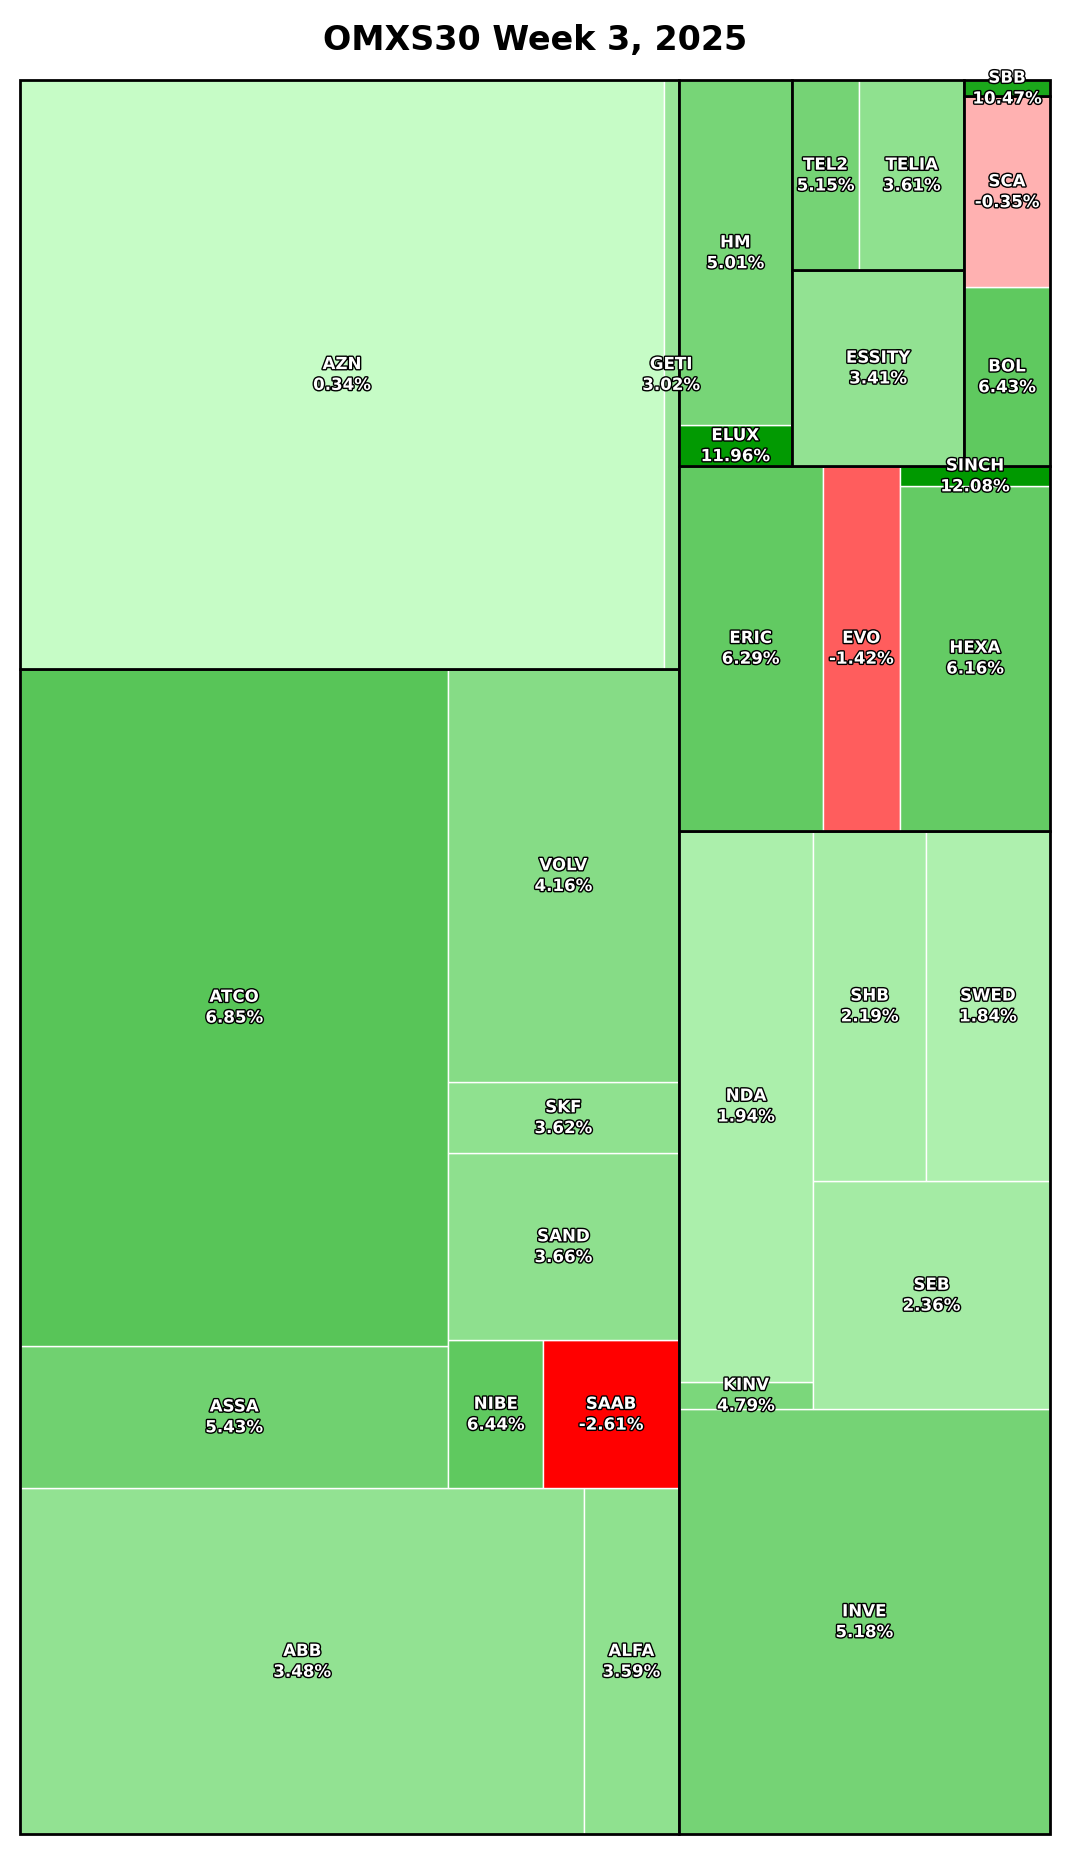

In [19]:
# Example Usage
generate_treemap_for_date_range(
    [info["SymbolYahoo"] for info in omxs30_info],
    omxs30_info,
    start_date="2025-01-13",
    end_date="2025-01-18",
    custom_title="OMXS30 Week 3, 2025"
)


#### week 4

In [ ]:
# # Example Usage
# generate_treemap_for_date_range(
#     [info["SymbolYahoo"] for info in omxs30_info],
#     omxs30_info,
#     start_date="2025-01-20",
#     end_date="2025-01-25",
#     custom_title="OMXS30 Week 4, 2025"
# )